In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy import stats
import os
import json
import pylab as pl
#s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'));
#pl.rcParams.update(s)

import matplotlib
%matplotlib nbagg
%pylab inline

#from __future__ import print_function, division
#import pylab as pl
#import numpy as np
#import matplotlib.pylab as pl

#from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#import statsmodels.api as sm

#%pylab inline
#%matplotlib inline

#from IPython.display import Image
#from IPython.display import clear_output
#pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

#import os
import urllib.request
import requests
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib

Populating the interactive namespace from numpy and matplotlib



This is the information I recieved about the data: "each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as

np.load(“MTA_Fare.npy") and

you will end up with a python numpy array of shape (600,23,194)

note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans: np.nanmean np.nansum...

# HINTS:
## notes and hints:
1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array

2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc

np.nanmean(mtarides)
np.nansum(mtarides)
as opposed to just

np.mean(mtarides)
np.sum(mtarides)

## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations.
 when I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - np.average(....weight=...) -. The sum and average functions take an axis argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

## Possibly useful functions
You are already familiar with and have already used most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient
the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...
the array methods
np.array.flatten()
np.array.reshape()
allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
mtaarray.flatten()
which returns the flatten array:

mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)

In [2]:
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy'

urllib.request.urlretrieve(url, 'MTA_Fare.npy')



('MTA_Fare.npy', <http.client.HTTPMessage at 0x7f59692466d8>)

In [3]:
mta = np.load('MTA_Fare.npy')


In [4]:
np.shape(mta)

(600, 23, 194)

In [5]:
np.mean(mta)

2157.8262034961899

In [6]:
mta = mta.astype('float')  #here we convert -1 to nans so they don't mess up our mean
mta[mta == -1] = np.nan


In [7]:
mtastations = np.nansum(mta, axis=1) #pablo Mandiola helped me with this ~ 
                                        #it flattens and makes NANS 0 
mtastations.shape

(600, 194)

(3.5, 6.0)

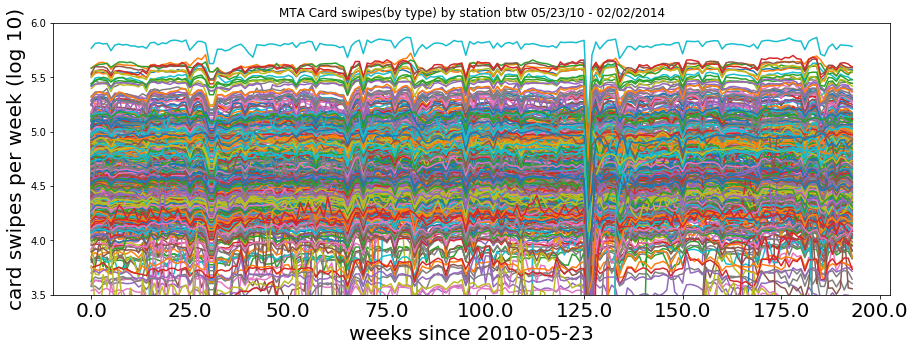

In [8]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(600):
    ax.plot(range(194),np.log10(mtastations[i]))
ax.legend(fontsize = 20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
pl.title("MTA Card swipes(by type) by station btw 05/23/10 - 02/02/2014")
pl.xlabel("weeks since 2010-05-23", fontsize=20)
pl.ylabel("card swipes per week (log 10)", fontsize=20)
pl.ylim(3.5, 6.0) 

#cyrus b. helped me with the for loop

#ax = mtastations.plt(x='weeks since 2010', y='weeks in the dataset', ax=ax)
#pl.annotate("Sandy", xy=[87,0], xytext=[90,10], fontsize=15)
#ax = trash.plot(x='Dump_Time_Stamp', y='Tons_Collected', ax=ax)
#ax.plot(trash.Dump_Time_Stamp, trash.Tons_Collected, '.', ms=50, label= "period = ?");
#ax.plot(trash.Dump_Time_Stamp, trash.Tons_Collected, '-', label = "trash pickup");

Figure 1: Time series analysis of mta card swipes by station across 4 years of data. Here we see that there are certain drops in ridership at various weeks (the most obivious being around week 125). Want to look at trends in the data (periodicity).

In [9]:
N = 3*52

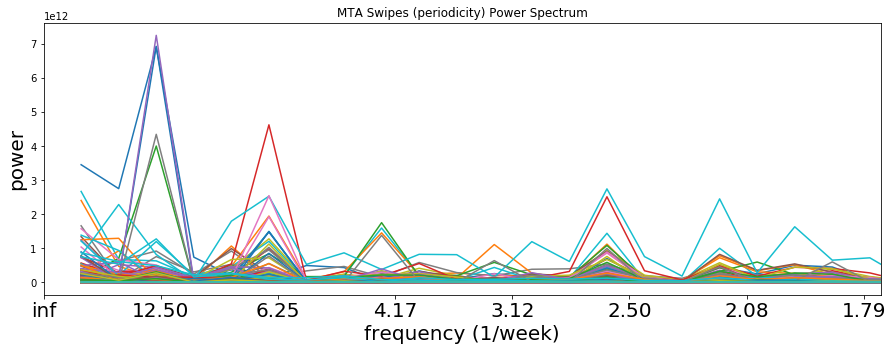

In [31]:
f = np.abs(np.fft.rfft(mtastations, n=N))**2  #code taken from fbianco fourier ui nb
fig = pl.figure(figsize=(15,5))  
ax = fig.add_subplot(111)
for i in range(600):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(f[i][1:]), '-') #this is a for loop that cyrus blankinship helped me with 
ax.set_xlim(0,1.0/7)
ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.title("MTA Swipes (periodicity) Power Spectrum")
pl.ylabel("power", fontsize=20)
pl.xlabel("frequency (1/week)", fontsize=20);

Figure 2: in this figure are the plots of the stations over frequency (which is defined as 1 week) and the power of those individual datasets in regards to their periodicity. 

# 4 weeks of high periodicity

In [30]:
find = np.argsort(f[0:,4]) 
find[:4]                 

array([599, 474, 475, 476])


These are the 4 stations that show the most periodicity in the data. I am not sure why i am getting 3 back to back stations as i can't visualize numpy arrays so i imagine that the it is wrong. 

From my limited knowledge of the domain i imagine that the periodicity is seen during holidays where less people are riding the subway. I would imagine thanksgiving and christmas are times of low ridership but this is strictly inference.
